# Comparison of developing and analog non-developing TCs

In [1]:
from waveFilter import kf_filter
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats
from functions_mpas_aqua import find_tcgen,find_tcgen_closedcontour,find_nondev_analogs_to_devtcs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from IPython.display import display
import datetime 

#increase font size
plt.rcParams.update({'font.size': 18})

Define basic information that will be used to access files, filter waves, etc.

In [2]:
expName = 'TC_3km'
# pth = "/glade/scratch/rberrios/MPAS_APE/aqua_sstmax10N/%s/"%expName

pth2tracks = '/glade/u/home/rberrios/projects/TCgenesis_mpasaqua/data/%s/'%expName
df_all = pd.read_csv(
    '%sTRACK_data_all_REFINED_CENTER_3km_35N1tstepwarmcore.csv'%pth2tracks)
df_all=df_all.rename(columns={'lon_pcentroid_pmin_r100':'lon','lat_pcentroid_pmin_r100':'lat'})
print(len(df_all.ID.unique()))
data_frames = list(df_all.groupby("ID"))
#tcgen_info = find_tcgen(data_frames)

# Set Pre-Defined Arguments for wave filtering
mis = -999
obsPerDay = 4
algoName='mpas'
minLat=0
maxLat=10

init_time = np.datetime64('2000-03-30 00:00:00')
obsVar = 'pr'
filtVar = obsVar
obsPerDay = 4 #six-hourly
# fname = pth+'latlon/diags_gaussian_global_alldays_n400.nc'

labels = ['DEV','non-DEV']

# build a rectangle in axes coords
left, width = .005, .5
bottom, height = .48, .5
right = left + width
top = bottom + height

223


Load TC genesis info.

In [3]:
tcgen_info = pd.read_csv('TCG_TC_3km_35N1tstepwarmcore_unstructuredmesh.csv')
# filter to keep equatorward of 30 N & make sure we remove 
# the intense TCs at the beginning of the tracking period
tcgen_info = tcgen_info[ (tcgen_info.lat<20) & (tcgen_info.pmin >= 990.0)]
print(len(tcgen_info))

108


In [4]:
tcgen_info[tcgen_info.ID==862]

,ID,fhr,valid_time,lat_TRACK,lon_TRACK,rmw,sym_rmw,lat,lon,rmw_pcentroid_pmin_r100,sym_rmw_pcentroid_pmin_r100,lat_pmin,lon_pmin,rmw_pmin,sym_rmw_pmin,vmax,pmin,test
27,862,606.0,2000-04-24_06.00.00,14.27113,317.183472,26.113823,192.5,13.602423,316.429552,100.614494,82.5,13.687489,316.30804,101.476486,12.5,13.703402,1010.393672,7


When do we want to find the analogs? Let's do 24 h before genesis for now.

In [5]:
analog_time=-24
tcgen_info_minust = []
for index, row in tcgen_info.iterrows():
    df_sub = df_all[df_all.ID==row['ID']]
    df_sub['fhr'] = df_sub['fhr']-row['fhr']
    df_sub_minust = df_sub[df_sub.fhr==analog_time]
    if (not df_sub_minust.empty):
        tcgen_info_minust.append(df_sub_minust)

tcgen_info_minust = pd.concat(tcgen_info_minust).reset_index(drop=True)

Call external function to find non-developing analogs to the developing TCs 

In [6]:
analogs_ndv,df_all = find_nondev_analogs_to_devtcs(pth2tracks,tcgen_info_minust)

[ 2.582027  2.40906   2.312925  2.029192  1.200742  0.597348 -0.209026
 -0.295199 -0.287383 -0.313156  0.183625  2.793881  2.96579   2.800579
  2.844099  3.339955  4.02207   4.585366  3.980286  3.853969  4.262788
  4.503884  4.565373  4.931085  6.02637   6.866757  7.557872  8.283062
  8.585677  8.687673  8.677943  8.943587  9.40799   9.748024 10.262077
 11.02377  11.729441 12.222872 12.611161 13.02086  13.427349 13.699285
 13.982995 14.27113  14.812611 15.32117  15.202389 15.289492 15.387282
 15.666413 15.963169 16.1346  ]
found 223 cyclone tracks
[ 2.582027  2.40906   2.312925  2.029192  1.200742  0.597348 -0.209026
 -0.295199 -0.287383 -0.313156  0.183625  2.793881  2.96579   2.800579
  2.844099  3.339955  4.02207   4.585366  3.980286  3.853969  4.262788
  4.503884  4.565373  4.931085  6.02637   6.866757  7.557872  8.283062
  8.585677  8.687673  8.677943  8.943587  9.40799   9.748024 10.262077
 11.02377  11.729441 12.222872 12.611161 13.02086  13.427349 13.699285
 13.982995 14.27113 

Rename coordinates to make my life easier later.

In [7]:
analogs_ndv=analogs_ndv.rename(columns={'lon_TRACK':'lon','lat_TRACK':'lat'})

#add valid time
valid_time = [datetime.datetime.strftime(date,format='%Y-%m-%d_%H.%M.%S')\
              for date in init_time+pd.to_timedelta(analogs_ndv.fhr,unit='h')]
analogs_ndv['valid_time']=valid_time

#------ save full TRACK data for the analogs -------#
df_NDV = df_all[(df_all.ID.isin(analogs_ndv.ID.unique()))]
# add valid time; different format than above
initial_time=pd.to_datetime('2000033000',format='%Y%m%d%H')
df_NDV['valid_time']=initial_time + pd.to_timedelta(df_NDV.fhr, unit='h')
df_NDV.to_csv('%snondeveloping_analogs.csv'%pth2tracks,index=False)

#------ save unique TC ids to a separate file ------#
test = ['%6.6i'%ID for ID in df_NDV.ID]
unique_ID = pd.DataFrame({'ID':test})
unique_ID.to_csv(pth2tracks+'/TC_IDs', index=False, header=False)

### Basic comparison of developing and non-developing analogs

Make several plots to make sure that the analogs are truly comparable to the developing TCs.

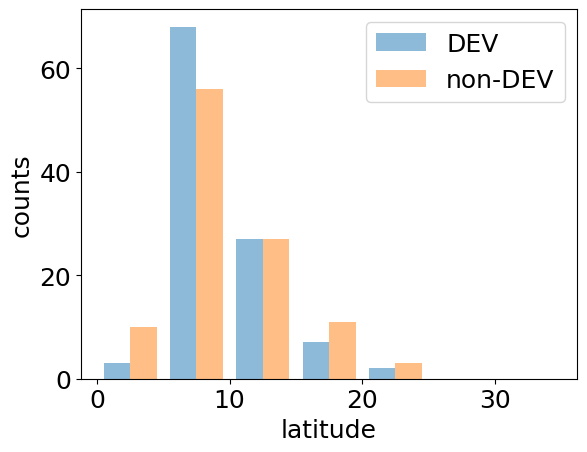

In [8]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.arange(0,40,5)
plt.figure()
plt.hist([tcgen_info_minust.lat,analogs_ndv.lat],bins=bins,alpha=0.5)
plt.xlabel('latitude')
plt.ylabel('counts')
plt.legend(labels)

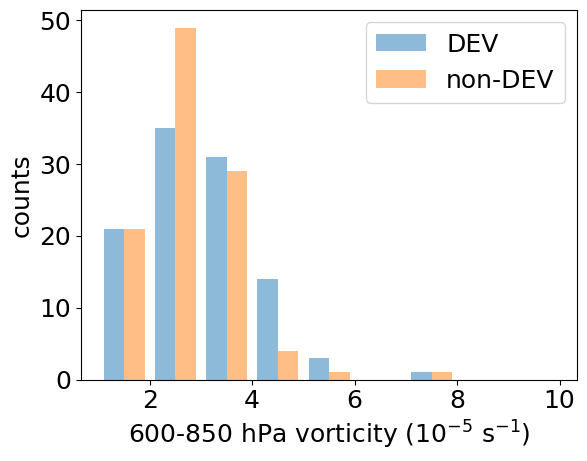

In [9]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.arange(1,11,1)
plt.figure()
plt.hist([tcgen_info_minust.vor850,analogs_ndv.vor850],bins=bins,alpha=0.5)
plt.ylabel('counts')
plt.xlabel('600-850 hPa vorticity (10$^{-5}$ s$^{-1}$)')
plt.legend(labels)

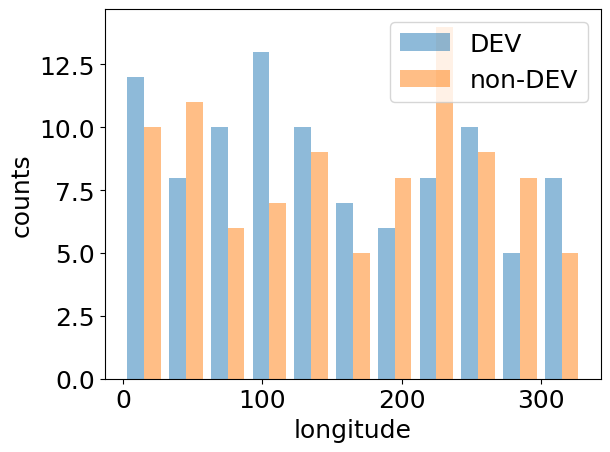

In [10]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.arange(0,360,30)
plt.figure()
plt.hist([tcgen_info_minust.lon,analogs_ndv.lon],bins=bins,alpha=0.5)
plt.ylabel('counts')
plt.xlabel('longitude')
plt.legend(labels)

In [11]:
analogs_ndv

,fhr,lon,lat,vor850,ID,f,valid_time
18010,2334.0,104.017441,9.271672,3.798710,4408,0.065198,2000-07-05_06.00.00
4326,498.0,225.592438,8.905334,2.359934,1116,0.000011,2000-04-19_18.00.00
23718,2958.0,52.715351,11.217921,2.901436,5862,0.000019,2000-07-31_06.00.00
9760,1188.0,254.779510,17.833521,5.441538,2438,0.067682,2000-05-18_12.00.00
5399,654.0,111.191986,10.411471,3.841640,1332,0.041417,2000-04-26_06.00.00
...,...,...,...,...,...,...,...
5875,690.0,27.795427,6.754120,2.575636,1500,0.050989,2000-04-27_18.00.00
1151,96.0,21.814199,7.701275,2.510917,206,0.022668,2000-04-03_00.00.00
3972,474.0,327.301666,8.091581,2.319635,1023,0.000138,2000-04-18_18.00.00
18255,2244.0,341.788330,4.064881,1.267681,4508,0.000210,2000-07-01_12.00.00


Plot time series of vorticity w.r.t. time of genesis or time of analog selection.

108
107


Text(0, 0.5, '600-850 hPa vorticity (s$^{-1}$)')

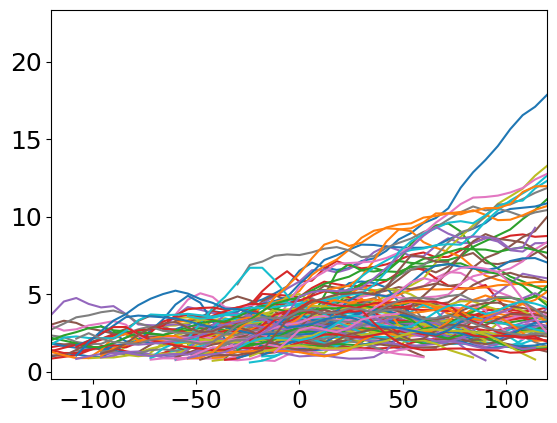

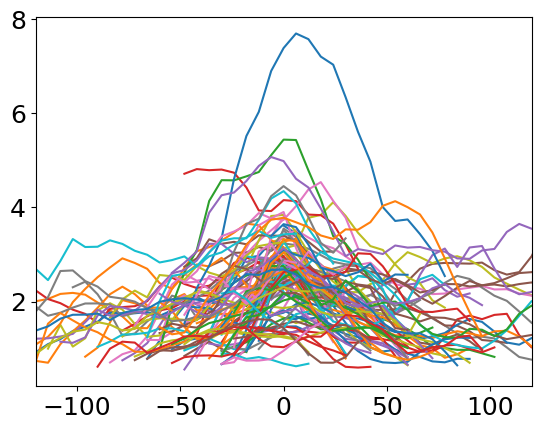

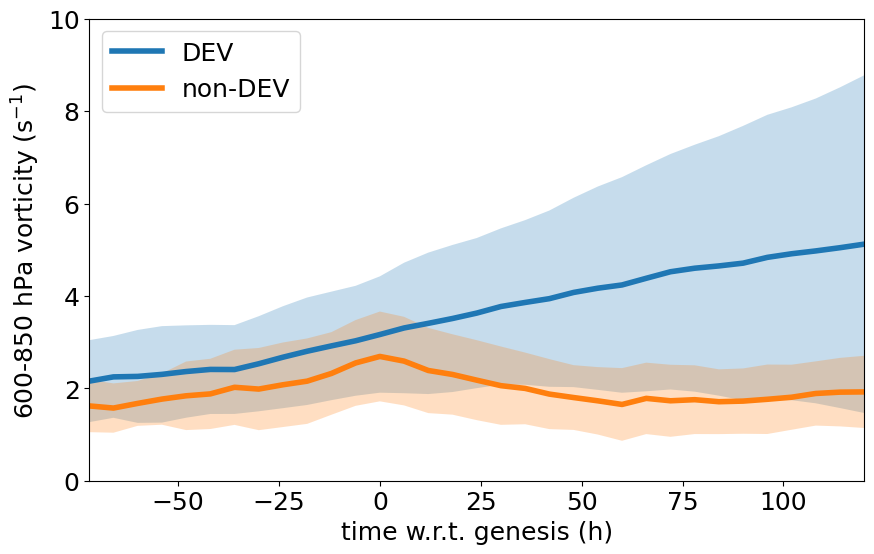

In [13]:
def get_avg_timeseries(subgroup,info):
    plt.figure()

    df_sub = df_all[df_all.ID.isin(subgroup)]
    print(len(df_sub.ID.unique()))

    out = []

    for i in df_sub.ID.unique():
        df_tc = df_sub[df_sub.ID==i]
        df_tc['fhr'] = df_tc['fhr'].values-info[info.ID==i].fhr.values
        out.append(df_tc)
        plt.plot(df_tc.fhr.values,df_tc.vor850)
    plt.xlim([-120,120])

    out = pd.concat(out)
    subgroup_avg = out.groupby('fhr').mean()
    subgroup_std = out.groupby('fhr').std()
    
    return subgroup_avg,subgroup_std

all_tcs = tcgen_info.ID.unique()
all_ndv = analogs_ndv.ID.unique()
avg_vor_tcs,std_vor_tcs = get_avg_timeseries(all_tcs,tcgen_info)
avg_vor_ndv,std_vor_ndv = get_avg_timeseries(all_ndv,analogs_ndv)

plt.figure(figsize=(10,6))
plt.plot(avg_vor_tcs.index,avg_vor_tcs.vor850,linewidth=4)
plt.plot(avg_vor_ndv.index,avg_vor_ndv.vor850,linewidth=4)

# add shading between -1/+1 sigma
plt.fill_between(avg_vor_tcs.index, avg_vor_tcs.vor850-std_vor_tcs.vor850, \
                 avg_vor_tcs.vor850+std_vor_tcs.vor850, alpha=0.25)
plt.fill_between(avg_vor_ndv.index, avg_vor_ndv.vor850-std_vor_ndv.vor850, \
                 avg_vor_ndv.vor850+std_vor_ndv.vor850, alpha=0.25)
plt.xlim([-72,120])
plt.ylim([0,10])
# labels = ['DEV (N = %i)'%len(tcs_on_peak),'non-DEV (N = %i)'%len(ndv_on_peak)]
plt.legend(labels,loc='upper left')
plt.xlabel('time w.r.t. genesis (h)')
plt.ylabel('600-850 hPa vorticity (s$^{-1}$)')

# plt.vlines(0,0,avg_vor_tcs.vor850.max())

# plt.savefig('timeseries_DEVvsnonDEV_vor850.jpg',bbox_inches='tight',dpi=150)

Developers and non-developers analogs are statistically similar up to the time of genesis. What's different then?